In [2]:
import function_list
import os

In [3]:
base_path,data,_ = function_list.folder_setup()

In [5]:
os.chdir(data)

In [9]:
board_games = pd.read_csv('bgg_db_2017_04.csv',encoding='latin-1')

In [11]:
board_games.columns.values

array(['rank', 'bgg_url', 'game_id', 'names', 'min_players', 'max_players',
       'avg_time', 'min_time', 'max_time', 'year', 'avg_rating',
       'geek_rating', 'num_votes', 'image_url', 'age', 'mechanic', 'owned',
       'category', 'designer', 'weight'], dtype=object)

In [70]:
board_games.corr()[board_games.corr()>.5].fillna('')

,rank,game_id,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,owned,weight
rank,1,,,,,,,,,,,,,
game_id,,1,,,,,,,,,,,,
min_players,,,1,,,,,,,,,,,
max_players,,,,1,,,,,,,,,,
avg_time,,,,,1,0.873736,0.999909,,,,,,,
min_time,,,,,0.873736,1,0.873613,,,,,,,
max_time,,,,,0.999909,0.873613,1,,,,,,,
year,,,,,,,,1,,,,,,
avg_rating,,,,,,,,,1,,,,,0.538311
geek_rating,,,,,,,,,,1,0.636099,,0.629257,


[]

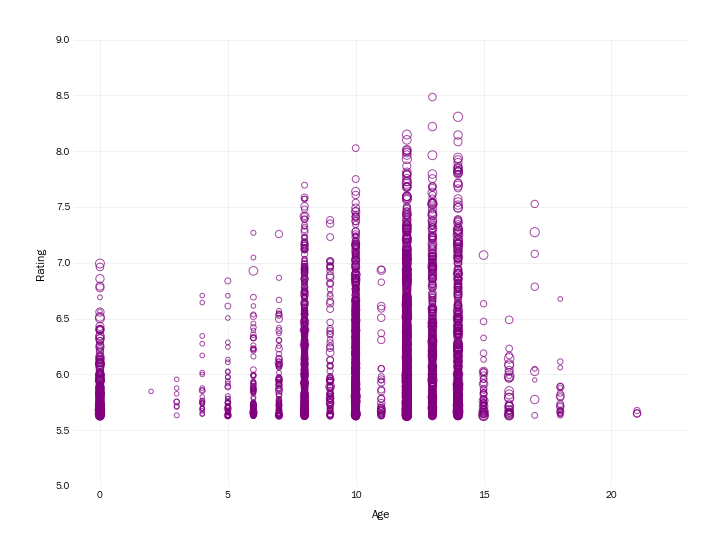

In [67]:

fig,ax = plt.subplots(figsize=(11,8))

plt.scatter(board_games['age'], board_games['geek_rating'],color='None',edgecolor='purple',
            s=board_games['weight']*20,alpha=.7)
ax.set_xlabel('Age')
ax.set_ylabel('Rating')
ax.set_xlim(-1,23)
plt.plot()

In [56]:
board_games[board_games['age']==board_games['age'].max()]['bgg_url']

4488    https://boardgamegeek.com/boardgame/97683/sout...
Name: bgg_url, dtype: object